<a href="https://colab.research.google.com/github/Elina-Filatova/image-classifier-deep-learning/blob/main/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pathlib
import shutil

import kagglehub
import pandas as pd
from fastai.vision.all import (
    CategoryBlock,
    DataBlock,
    EarlyStoppingCallback,
    GrandparentSplitter,
    ImageBlock,
    Normalize,
    Path,
    Precision,
    RandomSplitter,
    Recall,
    Resize,
    SaveModelCallback,
    ShowGraphCallback,
    accuracy,
    aug_transforms,
    cnn_learner,
    error_rate,
    get_image_files,
    imagenet_stats,
    parent_label,
    resnet34,
    vision_learner,
    ClassificationInterpretation,
    load_learner,
)
from PIL import Image

## Data Loading

In [ ]:
path_downloaded = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")
print("Path to dataset files:", path_downloaded)

source_folder = path_downloaded
destination_folder = "./fruits_vegetables"

try:
    shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)
    print(f"Folder copied successfully from {source_folder} to {destination_folder}")
except FileExistsError:
    print(f"The destination folder '{destination_folder}' already exists.")
except Exception as e:
    print(f"An error occurred: {e}")

100%|██████████| 1.98G/1.98G [00:20<00:00, 106MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8
Folder copied successfully from /root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8 to ./fruits_vegetables


In [ ]:
path = Path('fruits_vegetables/')
trainPath = path/'train'
testPath = path/'test'
validatePath = path/'validation'

### Datablock

In [ ]:
# path_lib = pathlib.Path(trainPath)
for img_path in trainPath.rglob("*.png"):
    img = Image.open(img_path)
    if img.mode == "P":
        img = img.convert("RGBA")
        img.save(img_path)

In [ ]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='validation'),
    get_y=parent_label,
    item_tfms=Resize(512),
    batch_tfms=[
        *aug_transforms(size=256, min_scale=0.75, max_rotate=15, flip_vert=True),
        Normalize.from_stats(*imagenet_stats),
    ],
)

### Dataloader

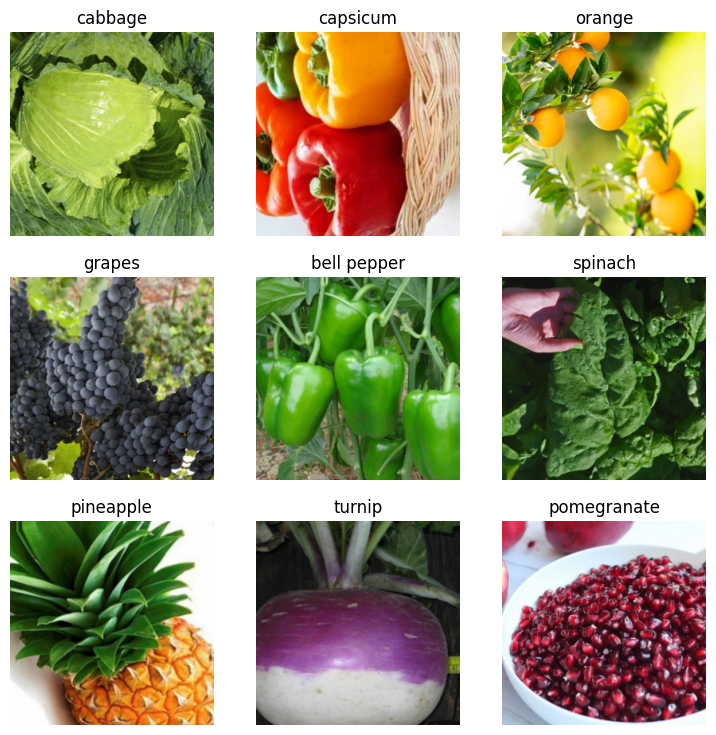

In [ ]:
dls = db.dataloaders(path, bs=128, verbose=False)
dls.show_batch()

## Training a Model
### Callbacks

In [ ]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='modelResnet34_fruits_vegetables', monitor='valid_loss')
]
metrics = [accuracy, Precision(average='micro'), Recall(average='micro')]
learn = vision_learner(dls, resnet34, metrics=metrics,cbs=callbacks).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 153MB/s]


### Building the model

### Learning Rate Finder

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

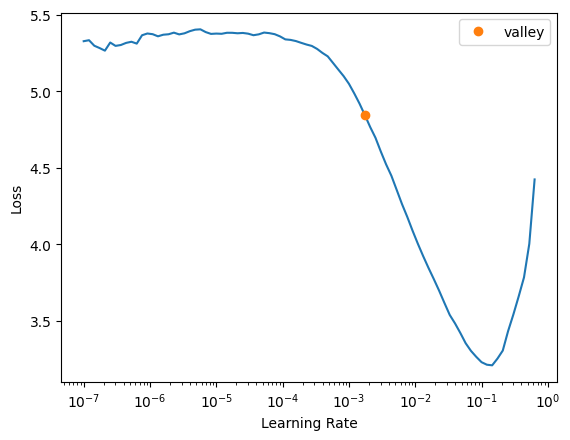

In [ ]:
learning_rate = learn.lr_find()

### Fine-Tuning

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,3.699001,0.727766,0.780627,0.780627,0.780627,02:40


Better model found at epoch 0 with valid_loss value: 0.7277664542198181.


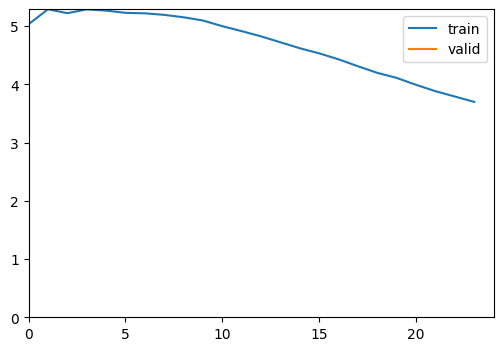

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.443138,0.440791,0.883191,0.883191,0.883191,02:39
1,1.183599,0.255419,0.923077,0.923077,0.923077,02:36
2,0.956513,0.194947,0.928775,0.928775,0.928775,02:39
3,0.771159,0.163972,0.940171,0.940171,0.940171,02:35
4,0.632969,0.142450,0.951567,0.951567,0.951567,02:37
5,0.518056,0.135168,0.962963,0.962963,0.962963,02:38
6,0.443139,0.156806,0.937322,0.937322,0.937322,02:35
7,0.371564,0.124029,0.965812,0.965812,0.965812,02:39
8,0.315183,0.122352,0.965812,0.965812,0.965812,02:39
9,0.281779,0.123380,0.965812,0.965812,0.965812,02:37


Better model found at epoch 0 with valid_loss value: 0.4407907724380493.


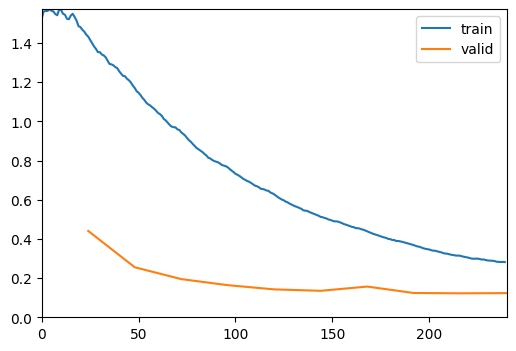

Better model found at epoch 1 with valid_loss value: 0.25541892647743225.
Better model found at epoch 2 with valid_loss value: 0.1949465572834015.
Better model found at epoch 3 with valid_loss value: 0.16397209465503693.
Better model found at epoch 4 with valid_loss value: 0.14245016872882843.
Better model found at epoch 5 with valid_loss value: 0.1351684033870697.
Better model found at epoch 7 with valid_loss value: 0.12402869015932083.
Better model found at epoch 8 with valid_loss value: 0.12235184758901596.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

In [ ]:
learn.fine_tune(10, base_lr=learning_rate.valley)

In [ ]:
Path('models').ls()

(#1) [Path('models/modelResnet34_fruits_vegetables.pth')]

In [ ]:
learn.to_fp32()
learn.export()
Path().ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

### Evaluating the model in the test set

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256,min_scale=0.75, max_rotate=15, flip_vert = True),
                             Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=128)

learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.9665738344192505.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

(#4) [0.1204427108168602,0.9665738344192505,0.9665738161559888,0.9665738161559888]

## Interpretation of the model

In [ ]:
learn.dls=dls

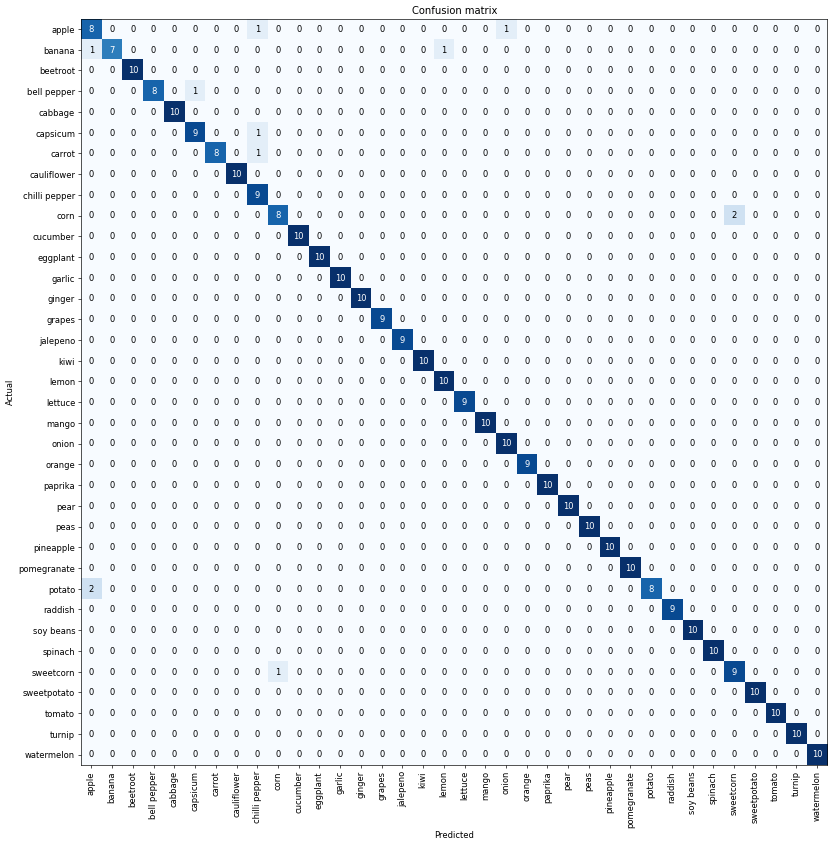

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize = (14,14), dpi = 60)

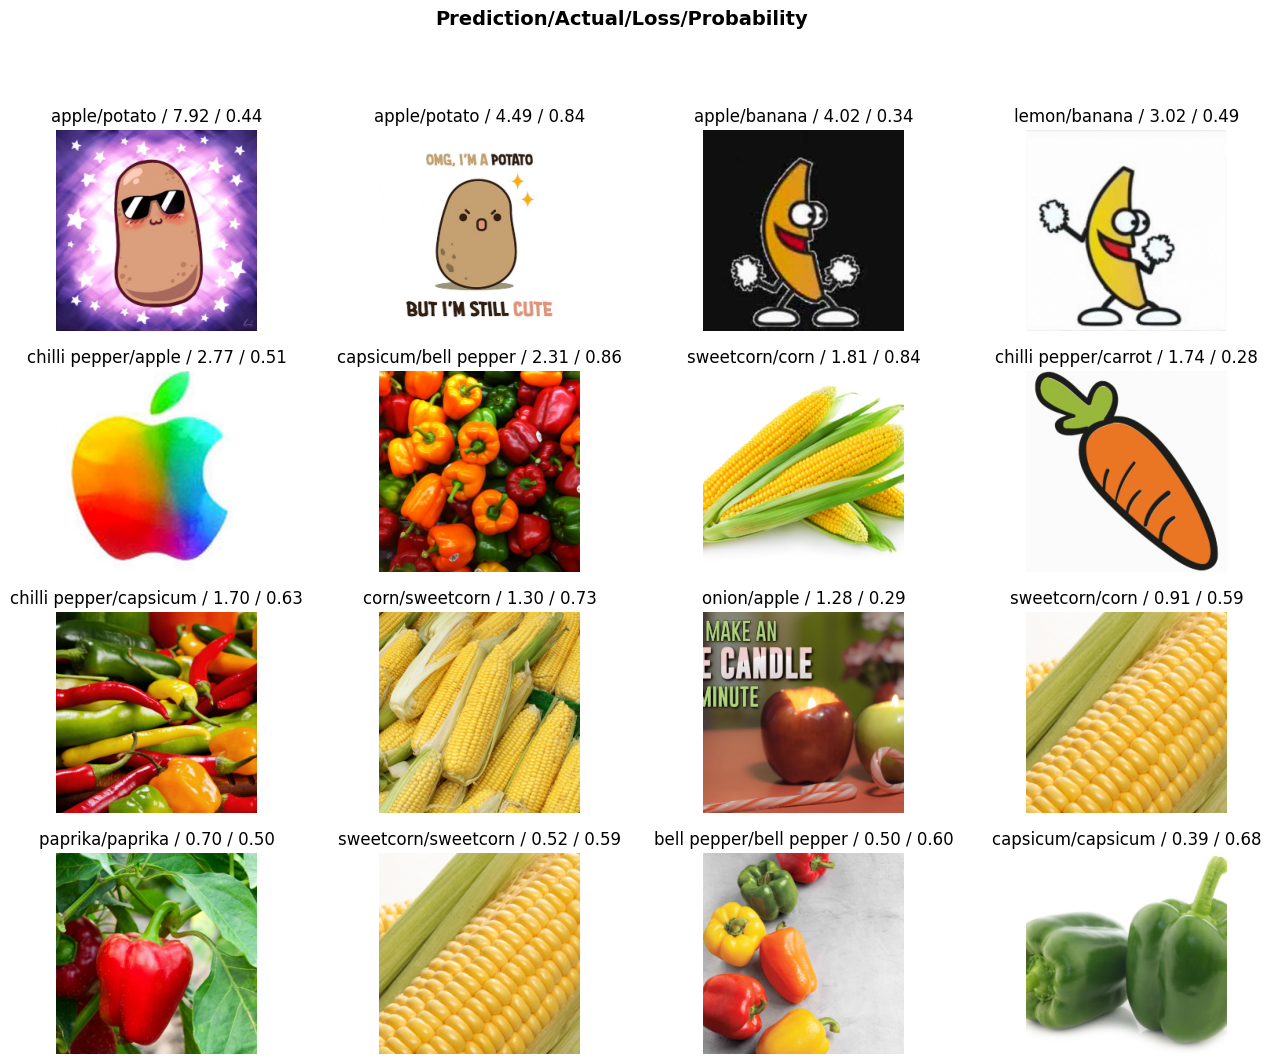

In [ ]:
interp.plot_top_losses(16, nrows=4, figsize=(16, 12))

In [ ]:
learn_inf = load_learner('export.pkl')

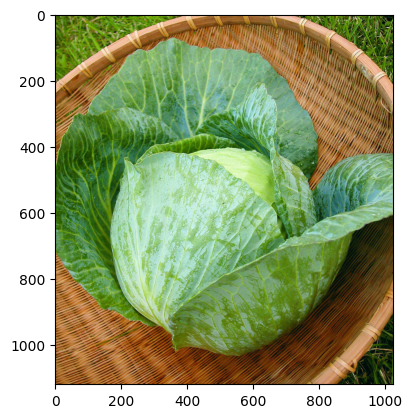

In [ ]:
import matplotlib.pyplot as plt
img_1 = plt.imread(testPath/'cabbage/Image_1.jpg')
plt.imshow(img_1)
plt.show()

In [ ]:
learn_inf.predict(img_1)

('cabbage',
 tensor(4),
 tensor([1.0032e-09, 3.1233e-09, 1.3572e-08, 2.1330e-09, 9.9998e-01, 1.0273e-09,
         2.3091e-08, 3.3225e-09, 1.6133e-10, 7.2506e-09, 7.7938e-07, 2.4929e-09,
         2.8368e-07, 4.1635e-10, 2.2111e-09, 8.2048e-12, 2.7792e-08, 2.3066e-07,
         1.6585e-05, 8.2414e-09, 5.2173e-09, 3.6484e-09, 1.0464e-09, 1.1634e-09,
         4.8511e-08, 4.4300e-09, 1.7919e-10, 1.1346e-09, 5.3978e-10, 1.3037e-09,
         2.1522e-06, 4.9407e-09, 6.0106e-08, 4.3309e-10, 6.6330e-09, 1.2437e-07]))

## Creating an application for our model

In [ ]:
!pip install huggingface_hub["fastai"] -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.8/447.8 kB 10.6 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from huggingface_hub import push_to_hub_fastai

repo_id = "el-filatova/image-classifier-deep-learning"
push_to_hub_fastai(learner=learn, repo_id=repo_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.pkl:   0%|          | 0.00/87.6M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/el-filatova/image-classifier-deep-learning/commit/2140980c1a2f42aac719a78509131714c7628864', commit_message='Push FastAI model using huggingface_hub.', commit_description='', oid='2140980c1a2f42aac719a78509131714c7628864', pr_url=None, repo_url=RepoUrl('https://huggingface.co/el-filatova/image-classifier-deep-learning', endpoint='https://huggingface.co', repo_type='model', repo_id='el-filatova/image-classifier-deep-learning'), pr_revision=None, pr_num=None)